# Caso de uso Hadoop

A continuación, se detalla un caso de uso en el cual se emplearán las herramientas instaladas. Se utilizará un cuaderno de Jupyter como plataforma de interacción mediante el uso de Python como lenguaje de programación. Se parte de la base de que el usuario ya posee un conocimiento básico sobre dicho lenguaje y del manejo de los cuadernos de Jupyter. Este cuaderno es una adaptación propia del artículo "How to use Spark SQL: A hands-on tutorial" del autor Dipanjan Sarkar publicado en la web opensource.com (https://opensource.com/article/19/3/apache-spark-and-dataframes-tutorial). 

Se empleará el dataset KDD Cup 1999 (https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Data), el cual consta de un conjunto de datos de red que se utilizaron en una competencia de minería de datos celebrada en 1999. El conjunto de datos representa una simulación de una red de computadoras de una empresa con actividades normales y anómalas. Se muestra una cantidad sustancial de tráfico normal de red, así como varios tipos de ataques simulados, como ataques de denial of service (DoS), ataques de intrusión remota a través de programas maliciosos y ataques de probing. El objetivo de la competencia era desarrollar modelos de detección de intrusiones que pudieran distinguir entre el tráfico normal y el tráfico anómalo. Cuenta con aproximadamente 5 millones de registros y se ha utilizado ampliamente en la investigación en el campo de la ciberseguridad. 

### Calentando motores

En primer lugar, se instalan las respectivas dependencias.

In [4]:

!pip install matplotlib
!pip install pandas



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


Se importan las librerías necesarias.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import os
import gzip
import shutil
import subprocess

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row


### Recuperación de los datos

Se descarga y descomprime el dataset en el sistema de archivos local. 

In [2]:

# Se define la fuente y el destino del dataset
url = "https://raw.githubusercontent.com/aj-data/HadoopVMProject/main/datasets/kddcup/kddcup.data.gz"
file_path = os.path.expanduser("~/temp/kddcup_data.gz")

# Se obtiene el dataset y se guarda en local
urllib.request.urlretrieve(url, file_path)

# Se verifica la descarga del dataset
if os.path.exists(file_path):
    print("El archivo se ha descargado en la siguiente ubicación:", file_path)
else:
    print("El archivo no se ha descargado o la ruta es incorrecta.")

# Se define la ruta para el archivo descomprimido
uncompressed_file_path = os.path.expanduser("~/temp/kddcup_data.csv")

# Se descomprime el archivo
with gzip.open(file_path, 'rb') as f_in:
    with open(uncompressed_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("El archivo se ha descomprimido correctamente en la siguiente ubicación:", uncompressed_file_path)


Luego se sube al sistema de archivos HDFS. 

In [3]:

# Ruta del archivo CSV local
local_file = uncompressed_file_path

# Ruta de destino en HDFS
hdfs_path = "/datasets/kddcup/kddcup_data.csv"

# Comando para subir el archivo a HDFS
command_folder = ["hdfs", "dfs", "-mkdir", "/datasets/kddcup"]
command_put = ["hdfs", "dfs", "-put", local_file, hdfs_path]

# Ejecutar los comandos
subprocess.run(command_folder)
subprocess.run(command_put)


### Instancia de SparkContext

Se crea una instancia SparkContext llamada "CasoDeUso" que sirve como interfaz para ejecutar de forma local cualquier programa Spark. Además, se ajusta el nivel de log para que solo muestre en panatalla los errores asociados al código. 

In [2]:

# Se crea un SparkContext
sc = SparkContext("local", "CasoDeUso")

# Ajusta el nivel de registro
sc.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/20 12:20:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Carga del dataset como RDD 

Una vez se tienen los datos almacenados en el sistema de archivos de HDFS, se cargan en la estructura de datos abstracta tradicional de Spark, esto es, Conjunto de Datos Distribuido Resistente, RDD por sus siglas en inglés. Los RDDs son la estructura central en Spark, permitiendo un procesamiento de datos en paralelo, distribuido y tolerante a fallos.  

In [3]:

# Se especifica la ruta del CSV en HDFS
hdfs_file_path = "hdfs://localhost:9000/datasets/kddcup/kddcup_data.csv"

# Se carga el CSV en RDD
rdd = sc.textFile(hdfs_file_path)


Se ejecutan operaciones sobre el RDD y se muestran, por ejemplo, las cinco primeras líneas del conjunto de datos para ver su forma. 

In [10]:
%%time

# Se cuenta el numero de lineas
line_count = rdd.count()

# Se muestran las primeras 5 lineas del RDD
lines = rdd.take(5)
for line in lines:
    print(line)


0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2,2,1.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3,3,1.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,4,4,1.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,normal.


Se verifica el tipo de rdd.

In [4]:

type(rdd)


pyspark.rdd.RDD

### Construcción del DataFrame de Spark

Un DataFrame de Spark es una estructura de datos que representa una colección distribuida de datos. Pueden ser construidos a partir de una amplia variedad de fuentes, como archivos de datos estructurados, tablas en Hive, bases de datos externas o RDDs existentes como en este caso.

Se crea una instancia de SQLContext a partir de un objeto SparkContext (sc), que es la entrada predeterminada para trabajar con Spark en Python. SQLContext se utiliza para crear DataFrames, ejecutar consultas SQL y acceder a funciones de agregación.

In [5]:

sqlContext = SQLContext(sc)
sqlContext 


/usr/local/spark/python/lib/pyspark.zip/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Cada entrada del RDD es una línea de datos separada por comas que primero se debe dividir antes de poder analizar y construir el DataFrame de Spark. 

In [7]:

csv_rdd = rdd.map(lambda row: row.split(","))
print(csv_rdd.take(2))
print(type(csv_rdd))


[['0', 'tcp', 'http', 'SF', '215', '45076', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0', '0', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.'], ['0', 'tcp', 'http', 'SF', '162', '4528', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '1', '1', '1.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']]
<class 'pyspark.rdd.PipelinedRDD'>


In [8]:

len(csv_rdd.take(1)[0])


42

Los datos de la KDD 99 Cup consisten en diferentes atributos capturados a partir de datos de conexión. En este ejercicio, solo se usarán algunas columnas específicas del conjunto de datos, cuyos detalles se especifican a continuación. 

| feature num | feat. name (nombre)| description (descripción)                                    | type (tipo)|
|-------------|--------------------|--------------------------------------------------------------|------------|
| 1           | duration           | longitud (número de segundos) de la conexión                 | continuo   |
| 2           | protocol_type      | tipo de protocolo, por ej. tcp, udp, etc.                    | discreto   |
| 3           | service            | servicio de red en el destino, por ej. http, telnet, etc.    | discreto   |
| 4           | src_bytes          | número de bytes de datos desde el origen hasta el destino    | continuo   |
| 5           | dst_bytes          | número de bytes de datos desde el destino hasta el origen    | continuo   |
| 6           | flag               | estado normal o de error de la conexión	                  | discreto   |
| 7           | wrong_fragment     | número de fragmentos "incorrectos"                           | continuo   |
| 8           | urgent             | número de paquetes urgentes                                  | continuo   |
| 9           | hot                | número de indicadores "calientes"                            | continuo   |
| 10          | num_failed_logins  | intentos de inicio de sesión fallidos                        | continuo   |
| 11          | num_compromised    | número de condiciones "comprometidas"                        | continuo   |
| 12          | su_attempted       | 1 si se intentó el comando "su root"; 0 de lo contrario      | discreto   |
| 13          | num_root           | número de accesos de "root"                                  | continuo   |
| 14          | num_file_creations | número de operaciones de creación de archivo                 | continuo   |
| 15          | label              | categorización de la conexión.                               | discreto   |



Se extraen las siguientes columnas en función de sus posiciones en cada punto de datos (fila) y se construye un nuevo RDD de la siguiente manera.

In [9]:

parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)



[Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=215, dst_bytes=45076, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=162, dst_bytes=4528, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=236, dst_bytes=1228, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=233, dst_bytes=2032, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp

Una vez los datos están ordenados y formateados se procede a construir el DataFrame de Spark. 

In [10]:

df = sqlContext.createDataFrame(parsed_rdd)
display(df.head(10))


[Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=215, dst_bytes=45076, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=162, dst_bytes=4528, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=236, dst_bytes=1228, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=233, dst_bytes=2032, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp

Se comprueba que df efectivamente sea un DataFrame de Spark.

In [11]:

type(df)


pyspark.sql.dataframe.DataFrame

In [12]:

df.printSchema()


root
 |-- duration: long (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- su_attempted: string (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- label: string (nullable = true)



### Construcción de una tabla temporal 

Es posible usar la función registerTempTable() para construir una tabla temporal y ejecutar comandos SQL en nuestro DataFrame. Hay que tener en cuenta que la duración de esta tabla temporal está vinculada a la sesión pues construye una tabla en memoria que está limitada al clúster en el que se creó. Los datos se almacenan utilizando el formato columnar en memoria altamente optimizado de Hive. 

In [18]:

help(df.registerTempTable)


Help on method registerTempTable in module pyspark.sql.dataframe:

registerTempTable(name: str) -> None method of pyspark.sql.dataframe.DataFrame instance
    Registers this :class:`DataFrame` as a temporary table using the given name.
    
    The lifetime of this temporary table is tied to the :class:`SparkSession`
    that was used to create this :class:`DataFrame`.
    
    .. versionadded:: 1.3.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    .. deprecated:: 2.0.0
        Use :meth:`DataFrame.createOrReplaceTempView` instead.
    
    Parameters
    ----------
    name : str
        Name of the temporary table to register.
    
    Examples
    --------
    >>> df = spark.createDataFrame([(2, "Alice"), (5, "Bob")], schema=["age", "name"])
    >>> df.registerTempTable("people")
    >>> df2 = spark.sql("SELECT * FROM people")
    >>> sorted(df.collect()) == sorted(df2.collect())
    True
    >>> spark.catalog.dropTempView("people")
    True



Mediante el siguiente código se contruye la tabla temporal basada en el DataFrame de Spark que se viene trabajando (df) y le asignamos el nombre de "connections". 

In [13]:

df.registerTempTable("connections")


/usr/local/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:330: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


### Ejecución de consultas SQL 

En este punto ya es posible aprovechar la capacidad de ejecutar consultas SQL sobre la tabla temporal basada en nuestro DataFrame de Spark. Se comienza con algunas consultas simples y luego se harán agregaciones, filtros, ordenamiento, subconsultas y pivotes. 

En primer lugar, se obtiene el número total de conexiones según el tipo de protocolo de conexión. Se calcula esta información utilizando las funciones de agregación tradicionales. 

In [20]:

%%time

df.groupBy('protocol_type').count().orderBy('count', ascending=False).show()


+-------------+-------+
|protocol_type|  count|
+-------------+-------+
|         icmp|2833545|
|          tcp|1870598|
|          udp| 194288|
+-------------+-------+

CPU times: user 19.6 ms, sys: 9.52 ms, total: 29.1 ms
Wall time: 1min 28s


De forma alternativa, se realiza la misma consulta con consultas SQL propiamente. 

In [28]:

%%time

protocols = sqlContext.sql("""
                           SELECT protocol_type, count(*) as freq
                           FROM connections
                           GROUP BY protocol_type
                           ORDER BY 2 DESC
                           """)

protocols.show()


+-------------+-------+
|protocol_type|   freq|
+-------------+-------+
|         icmp|2833545|
|          tcp|1870598|
|          udp| 194288|
+-------------+-------+

CPU times: user 16.8 ms, sys: 14.1 ms, total: 30.9 ms
Wall time: 1min 31s


Como se puede observar, el resultado es el mismo. Esto confirma que es posible aprovechar todas las ventajas de Spark sin necesidad de aprender un nuevo lenguaje y realizando consultas en lenguaje SQL. 

Se muestra una tabla de frecuencias ordenada de la columna "label" que describe el tipo de conexión.

In [16]:

%%time

labels = sqlContext.sql("""
                           SELECT label, count(*) as freq
                           FROM connections
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)
labels.show()


+----------------+-------+
|           label|   freq|
+----------------+-------+
|          smurf.|2807886|
|        neptune.|1072017|
|         normal.| 972781|
|          satan.|  15892|
|        ipsweep.|  12481|
|      portsweep.|  10413|
|           nmap.|   2316|
|           back.|   2203|
|    warezclient.|   1020|
|       teardrop.|    979|
|            pod.|    264|
|   guess_passwd.|     53|
|buffer_overflow.|     30|
|           land.|     21|
|    warezmaster.|     20|
|           imap.|     12|
|        rootkit.|     10|
|     loadmodule.|      9|
|      ftp_write.|      8|
|       multihop.|      7|
+----------------+-------+
only showing top 20 rows

CPU times: user 29.5 ms, sys: 4.26 ms, total: 33.7 ms
Wall time: 1min 28s


Aprovechando la flexibilidad que nos proporciona emplear SQL, se hace una consulta que devuelva una lista de frecuencias ordenada de mayor a menor de las etiquetas asignadas a cada una de las conexiones donde "normal" corresponde a conexiones regulares no ofensivas y cualquier otro valor indica una potencial conexión maliciosa. 

In [14]:

%%time

labels_bin = sqlContext.sql("""
                            SELECT 
                              CASE 
                                WHEN label = 'normal.' THEN 'normal'
                                ELSE 'ataque' 
                              END AS tipo_conexion, 
                              COUNT(*) AS count,
                              CONCAT(ROUND(COUNT(*) / (SELECT COUNT(*) FROM connections) * 100, 2), '%') 
                              AS porcentaje
                            FROM connections 
                            GROUP BY 
                              CASE 
                                WHEN label = 'normal.' THEN 'normal'
                                ELSE 'ataque' 
                              END 
                            ORDER BY count DESC
                           """)
labels_bin.show()

+-------------+-------+----------+
|tipo_conexion|  count|porcentaje|
+-------------+-------+----------+
|       ataque|3925650|    80.14%|
|       normal| 972781|    19.86%|
+-------------+-------+----------+

CPU times: user 46.8 ms, sys: 3.88 ms, total: 50.7 ms
Wall time: 2min 48s


Incluso es posible mostrar la frecuencia de los accesos en un gráfico de barras. 

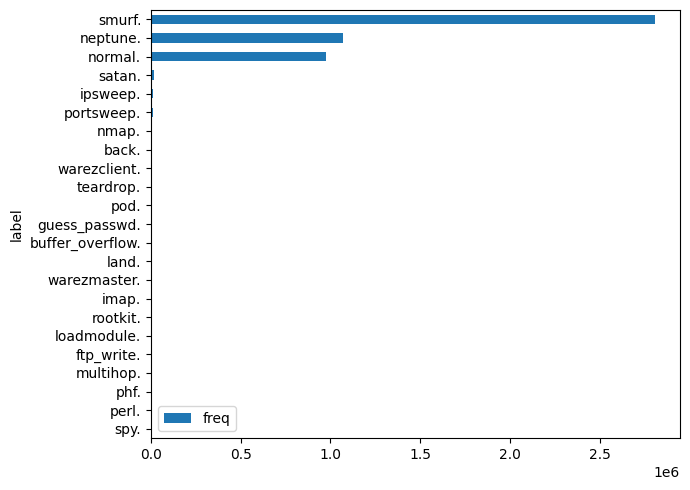

CPU times: user 364 ms, sys: 0 ns, total: 364 ms
Wall time: 536 ms


In [23]:

%%time

labels_df = pd.DataFrame(labels.toPandas())
labels_df.set_index("label", drop=True, inplace=True)
labels_fig = labels_df.plot(kind='barh')
labels_fig.invert_yaxis()

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()

plt.show()


Puede resultar interesante ver qué protocolos son más vulnerables a los ataques con la siguiente consulta SQL. 

In [31]:

%%time

attack_protocol = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as freq
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
attack_protocol.show()


+-------------+---------+-------+
|protocol_type|    state|   freq|
+-------------+---------+-------+
|         icmp|   attack|2820782|
|          tcp|   attack|1101928|
|          tcp|no attack| 768670|
|          udp|no attack| 191348|
|         icmp|no attack|  12763|
|          udp|   attack|   2940|
+-------------+---------+-------+

CPU times: user 28 ms, sys: 22.4 ms, total: 50.4 ms
Wall time: 1min 55s


Según el resultado de la anterior consulta los protocolos más vulnerables son ICMP y TCP.

Incluso se pueden realizar cálculos estadísticos relacionados con los eventos de conexión según el protocolo. 

In [37]:

%%time

attack_stats = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
pandas_df = attack_stats.toPandas()

pandas_df


CPU times: user 53.5 ms, sys: 75.7 ms, total: 129 ms
Wall time: 1min 40s


,protocol_type,state,total_freq,mean_src_bytes,mean_dst_bytes,mean_duration,total_failed_logins,total_compromised,total_file_creations,total_root_attempts,total_root_acceses
0,icmp,attack,2820782,931.68,0.00,0.00,0,0,0,0.0,0
1,tcp,attack,1101928,4465.81,2005.96,22.60,61,2276,96,1.0,159
2,tcp,no attack,768670,1844.29,4071.32,11.48,96,37344,5727,179.0,63202
3,udp,no attack,191348,98.32,89.41,1061.26,0,0,0,0.0,0
4,icmp,no attack,12763,90.68,0.00,0.00,0,0,0,0.0,0
5,udp,attack,2940,26.40,0.82,0.00,0,0,0,0.0,0


In [46]:
# Recuerda detener el SC una vez finalizados todos los procesos 
 sc.stop()

Como se ha podido observar a lo largo de este capítulo, es posible realizar consultas en SQL sobre nuestro dataset sin necesidad de aprender un nuevo lenguaje como lo sería Scala. Igualmente, se aprovecha el rendimiento que ofrece Spark y el almacenamiento distribuido en HDFS, con la practicidad de trabajar desde un cuaderno de Jupyter. 